C:\Users\Padilla-Coreano\.conda\envs\WaveMAP\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Error processing data in D:\pc_lab\RCE\finished_proc\phy_curation\20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged.rec: 'NoneType' object is not subscriptable
Error processing data in D:\pc_lab\RCE\finished_proc\phy_curation\20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged.rec: 'NoneType' object is not subscriptable
Error processing data in D:\pc_lab\RCE\finished_proc\phy_curation\20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged.rec: 'NoneType' object is not subscriptable
Error processing data in D:\pc_lab\RCE\finished_proc\phy_curation\20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged.rec: 'NoneType' object is not subscriptable
Error processing data in D:\pc_lab\RCE\finished_proc\phy_curation\20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged.rec: 'NoneType' object is not subscriptable
Error processing data in D:\pc_lab\RCE\finished_proc\phy_curation\20230620_114347_standard

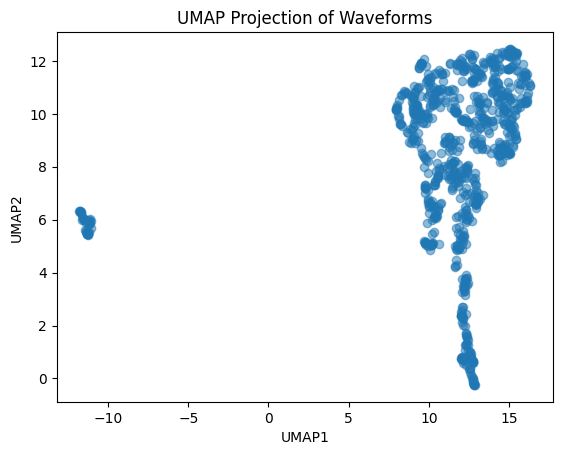

In [1]:
import os
import pandas as pd
import numpy as np
import concurrent.futures
from phylib.io.model import load_model
from umap import UMAP
from sklearn.preprocessing import normalize
from matplotlib import pyplot as plt

# Constants
BASE_DIR = r'D:\pc_lab\RCE\finished_proc\phy_curation'
RAND_STATE = 42
SAVE_PATH = r'D:\pc_lab\RCE\meanWave_clust_rec_fr.npy'  # Path to save the waveform data

def process_folder(folder):
    cluster_info_path = os.path.join(folder, 'phy', 'cluster_info.tsv')
    params_path = os.path.join(folder, 'phy', 'params.py')
    recording_name = os.path.basename(folder)
    
    # Read the TSV file
    try:
        cluster_info = pd.read_csv(cluster_info_path, sep='\t')
    except Exception as e:
        print(f"Error reading {cluster_info_path}: {e}")
        return []

    try:
        good_clusters = cluster_info[
            (cluster_info['group'] == 'good') & 
            (cluster_info['fr'] > 0.5)
        ][['cluster_id', 'fr']]
        
        # Load the TemplateModel
        model = load_model(params_path)
        
        # Initialize a list to store the mean waveforms, cluster IDs, firing rates, and recording names
        mean_waveforms = []
        cluster_ids = []
        firing_rates = []
        recording_names = []
        
        for _, row in good_clusters.iterrows():
            cluster_id = row['cluster_id']
            firing_rate = row['fr']
            
            # Get cluster spike waveforms
            waveforms = model.get_cluster_spike_waveforms(cluster_id)[:, :, 0]
            # Calculate the mean waveform and normalize it
            mean_waveform = waveforms.mean(axis=0)
            norm_mean_waveform = normalize(mean_waveform.reshape(1, -1), norm='max').squeeze()
            mean_waveforms.append(norm_mean_waveform)
            cluster_ids.append(cluster_id)
            firing_rates.append(firing_rate)
            recording_names.append(recording_name)
        
        return list(zip(mean_waveforms, cluster_ids, firing_rates, recording_names))
    
    except Exception as e:
        print(f"Error processing data in {folder}: {e}")
        return []

def main():
    # Retrieve all recording folders
    folders = [os.path.join(BASE_DIR, f) for f in os.listdir(BASE_DIR) if os.path.isdir(os.path.join(BASE_DIR, f))]
    
    # Process each folder
    results = []
    with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
        for result in executor.map(process_folder, folders):
            if result:
                results.extend(result)

    # Combine all waveforms, cluster IDs, firing rates, and recording names into a single list
    if not results:
        print("No waveforms found.")
        return

    normWFs_array = np.array([r[0] for r in results])
    cluster_ids = np.array([r[1] for r in results])
    firing_rates = np.array([r[2] for r in results])
    recording_names = np.array([r[3] for r in results])

    # Save the results to a file
    np.save(SAVE_PATH, {'waveforms': normWFs_array, 'cluster_ids': cluster_ids, 'firing_rates': firing_rates, 'recording_names': recording_names})

    # Perform UMAP
    reducer = UMAP(random_state=RAND_STATE, n_neighbors=15)
    embedding = reducer.fit_transform(normWFs_array)

    # Plotting
    plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.5)
    plt.title('UMAP Projection of Waveforms')
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.show()

if __name__ == "__main__":
    main()